In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import make_classification, make_regression
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import noisereduce as nr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import whisper
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import noisereduce as nr
from scipy.signal import butter, filtfilt
import whisper  # Import the Whisper library 

ModuleNotFoundError: No module named 'librosa'

In [9]:
import whisper

# Load the Whisper model
model = whisper.load_model("base")

# Load and preprocess the audio
audio = whisper.load_audio("original_audio.mp3")
audio = whisper.pad_or_trim(audio)

# Generate the log-Mel spectrogram
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# Detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# Decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

# Print the transcription
print(result.text)


c:\Users\caspe\anaconda3\envs\BIRD\Lib\site-packages\whisper\__init__.py:69: UserWarning: C:\Users\caspe\.cache\whisper\base.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(
100%|████████████████████████████████████████| 139M/139M [04:40<00:00, 518kiB/s]


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [6]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import whisper
print(whisper.__version__)

print("GPUs Available:", tf.config.list_physical_devices('GPU'))


2.19.0
[]
20240930
GPUs Available: []


## Preprocess

In [4]:
# ============================
# Global Parameters & Paths
# ============================
SR = 32000               # Audio sampling rate (32 kHz)
N_MELS = 128             # Number of Mel bands for spectrograms (used in our custom pipeline)
HOP_LENGTH = 512         # Hop length for spectrogram computation
DURATION = 5.0           # Duration (seconds) for each training segment
BATCH_SIZE = 8

# Directories (adjust these paths as needed)
BASE_DIR = r"C:\BIRD"  # Base directory
CODE_DIR = os.path.join(BASE_DIR, "Code")  # Code directory
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
TRAIN_SOUNDCAPES_DIR = os.path.join(BASE_DIR, "train_soundscapes")
TEST_SOUNDCAPES_DIR = os.path.join(BASE_DIR, "test_soundscapes")

# ============================
# Data Ingestion & Exploration
# ============================
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train.csv")
SAMPLE_SUBMISSION_PATH = os.path.join(BASE_DIR, "sample_submission.csv")
TAXONOMY_PATH = os.path.join(BASE_DIR, "taxonomy.csv")
REF_LOC = os.path.join(BASE_DIR, "recording_location.txt")

# Read metadata files
train_df = pd.read_csv(TRAIN_CSV_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
taxonomy_df = pd.read_csv(TAXONOMY_PATH)

with open(REF_LOC) as f:
    recording_location_info = f.read()

print("First few rows of training metadata:")
print(train_df.head())
print("\nDataset info:")
print(train_df.info())

# ============================
# Audio Processing Functions
# ============================

def load_audio(path, sr=SR, duration=None):
    """
    Loads an audio file.
    """
    audio, _ = librosa.load(path, sr=sr, duration=duration)
    return audio  

def bandpass_filter(audio, lowcut=300.0, highcut=8000.0, sr=SR, order=6):
    """
    Applies a Butterworth bandpass filter.
    """
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    # If audio is very short, skip filtering
    if len(audio) < order:
        return audio
    return filtfilt(b, a, audio)

def adaptive_noise_reduction(audio, sr=SR):
    """
    Reduces background noise using adaptive noise estimation and spectral gating.
    """
    reduced_audio = nr.reduce_noise(y=audio, sr=sr, stationary=False)
    return reduced_audio

def compute_mel_spectrogram(audio, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    """
    Computes a Mel-spectrogram and converts power to decibel scale.
    """
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def process_mel_spectrogram(audio):
    """
    Applies filtering and computes a Mel spectrogram using our custom pipeline.
    """
    audio_bandpassed = bandpass_filter(audio)
    audio_denoised = adaptive_noise_reduction(audio_bandpassed)
    mel_spec = compute_mel_spectrogram(audio_denoised)
    return mel_spec

# ----- NEW: Whisper Preprocessing Functions -----
# Load the pre-trained Whisper model (using "base" as an example)
model_whisper = whisper.load_model("base")

def preprocess_whisper_audio(audio, sr=SR):
    """
    Resamples audio to 16 kHz, pads/trims, and computes Whisper's log-mel spectrogram.
    This provides a rich, pre-trained embedding.
    """
    # Resample audio to 16 kHz if necessary
    target_sr = 16000
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    # Whisper provides a helper to pad or trim audio
    audio = whisper.pad_or_trim(audio)
    # Compute the log-mel spectrogram using Whisper's utility
    mel_spec = whisper.log_mel_spectrogram(audio).cpu().numpy()
    return mel_spec

# Optional: Visualize a sample spectrogram (custom or Whisper-based)
def plot_spectrogram(mel_spec, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Process a subset of audio files for exploration
subset_size = int(len(train_df) * 0.01)
subset_files = random.sample(train_df["filename"].tolist(), subset_size)

processed_spectrograms = []
whisper_spectrograms = []
for file_path in subset_files:
    full_path = os.path.join(TRAIN_AUDIO_DIR, file_path)
    audio = load_audio(full_path, duration=DURATION)
    
    # Custom processing
    processed_mel_spec = process_mel_spectrogram(audio)
    processed_spectrograms.append(processed_mel_spec)
    
    # Whisper-based processing
    whisper_mel_spec = preprocess_whisper_audio(audio, sr=SR)
    whisper_spectrograms.append(whisper_mel_spec)

print(f"Processed {len(processed_spectrograms)} custom spectrograms (10% of dataset).")
print(f"Processed {len(whisper_spectrograms)} Whisper spectrograms (10% of dataset).")

# ============================
# Label Preparation
# ============================
species_codes = sorted(train_df["primary_label"].unique())
species_to_index = {code: i for i, code in enumerate(species_codes)}
num_species = len(species_codes)
print(f"Number of unique species: {num_species}")

def label_to_onehot(label):
    onehot = np.zeros(num_species, dtype=np.float32)
    if label in species_to_index:
        onehot[species_to_index[label]] = 1.0
    return onehot

train_file_paths = [os.path.join(TRAIN_AUDIO_DIR, fname) for fname in train_df["filename"].values]
train_labels = [label_to_onehot(lbl) for lbl in train_df["primary_label"].values]

# ============================
# Data Generator using Whisper Features
# ============================
def generator(paths, labels):
    """
    For each audio file, load the audio and extract Whisper features.
    Optionally, you can combine these with your custom mel spectrogram features.
    """
    for path, label in zip(paths, labels):
        audio = load_audio(path, duration=DURATION)
        # Get Whisper features
        whisper_spec = preprocess_whisper_audio(audio, sr=SR)
        # For simplicity, we average over time to get a fixed-length embedding
        whisper_embedding = np.mean(whisper_spec, axis=1)  # shape: (embedding_dim,)
        
        # Optionally, combine with custom features:
        custom_mel = process_mel_spectrogram(audio)
        custom_embedding = np.mean(custom_mel, axis=1)  # shape: (N_MELS,)
        
        # Concatenate Whisper embedding with custom mel embedding
        combined_features = np.concatenate((whisper_embedding, custom_embedding), axis=-1)
        # Yield a 1D feature vector and its corresponding label
        yield combined_features, label

# Determine the output shape:
# Let whisper embedding dimension be D_whisper and custom embedding be N_MELS.
# For example, if D_whisper == 80 (typical for Whisper) and N_MELS == 128, then final dimension is 208.
dummy_audio = load_audio(train_file_paths[0], duration=DURATION)
dummy_whisper = np.mean(preprocess_whisper_audio(dummy_audio, sr=SR), axis=1)
dummy_custom = np.mean(process_mel_spectrogram(dummy_audio), axis=1)
final_feature_dim = dummy_whisper.shape[0] + dummy_custom.shape[0]
print("Final feature dimension:", final_feature_dim)

# Set output shapes accordingly. Here, each sample is a vector of fixed length.
output_shapes = ((final_feature_dim,), (num_species,))
output_types = (tf.float32, tf.float32)

train_paths, val_paths, train_lab, val_lab = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_generator(lambda: generator(train_paths, train_lab),
                                                 output_types=output_types,
                                                 output_shapes=output_shapes)
val_dataset = tf.data.Dataset.from_generator(lambda: generator(val_paths, val_lab),
                                               output_types=output_types,
                                               output_shapes=output_shapes)

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

First few rows of training metadata:
  primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name         

NameError: name 'random' is not defined

## visualize random sample

Audio files saved as 'original_audio.wav' and 'processed_audio.wav'.


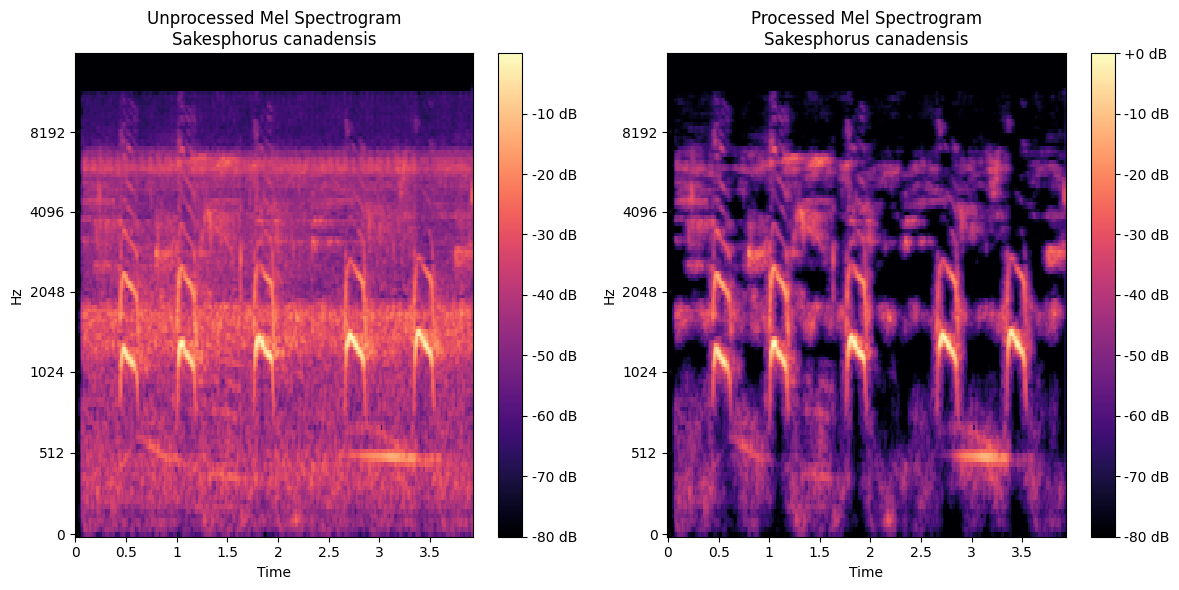

Animal name: Sakesphorus canadensis


In [8]:
import os
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

# Assuming these global constants and functions (load_audio, compute_mel_spectrogram, process_mel_spectrogram, etc.) are defined as before
# For example:
SR = 32000
N_MELS = 128
HOP_LENGTH = 512
DURATION = 5.0
TRAIN_AUDIO_DIR = r"C:\BIRD\train_audio"

# Process a subset of files
subset_files = random.sample(train_df["filename"].tolist(), int(len(train_df) * 0.004))

processed_spectrograms = []
for file_name in subset_files:
    full_path = os.path.join(TRAIN_AUDIO_DIR, file_name)
    audio = load_audio(full_path, duration=DURATION)
    processed_mel_spec = process_mel_spectrogram(audio)
    processed_spectrograms.append(processed_mel_spec)

# Later, select a random sample from the same subset
if processed_spectrograms:
    random_idx = random.randint(0, len(processed_spectrograms) - 1)

    # Use the same file from subset_files so the IDs match
    selected_file = subset_files[random_idx]
    full_path = os.path.join(TRAIN_AUDIO_DIR, selected_file)
    
    # Load the corresponding original audio and compute its Mel spectrogram (unprocessed)
    audio = load_audio(full_path, duration=DURATION)
    original_mel_spec = compute_mel_spectrogram(audio)
    
    # Retrieve the processed spectrogram computed earlier
    processed_mel_spec = processed_spectrograms[random_idx]

    # Reconstruct audio from both spectrograms using Griffin-Lim
    original_audio_reconstructed = invert_mel_spectrogram(original_mel_spec)
    processed_audio_reconstructed = invert_mel_spectrogram(processed_mel_spec)

    # Save the reconstructed audio files
    sf.write("original_audio.wav", original_audio_reconstructed, SR)
    sf.write("processed_audio.wav", processed_audio_reconstructed, SR)

    print("Audio files saved as 'original_audio.wav' and 'processed_audio.wav'.")

    # Retrieve scientific name if needed (using train_df to match the filename)
    scientific_name = train_df[train_df["filename"] == selected_file].iloc[0]["scientific_name"]

    # Plot the spectrograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(original_mel_spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.title(f"Unprocessed Mel Spectrogram\n{scientific_name}")
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(1, 2, 2)
    librosa.display.specshow(processed_mel_spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.title(f"Processed Mel Spectrogram\n{scientific_name}")
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    print(f"Animal name: {scientific_name}")
else:
    print("No spectrograms were processed. Check data processing.")


## Save processed spectrograms

In [3]:
import pickle
with open(os.path.join(BASE_DIR, "processed_spectrograms.pkl"), "wb") as f:
    pickle.dump(processed_spectrograms, f)

# Load processed spectrograms
with open(os.path.join(BASE_DIR, "processed_spectrograms.pkl"), "rb") as f:
    loaded_spectrograms = pickle.load(f)

print("Processed spectrograms saved and loaded successfully.")

Processed spectrograms saved and loaded successfully.


## Clustering and dimensionality reduction methods TEST

c:\Users\caspe\anaconda3\envs\SPIKEDETEC\lib\site-packages\umap\umap_.py:1953: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism."


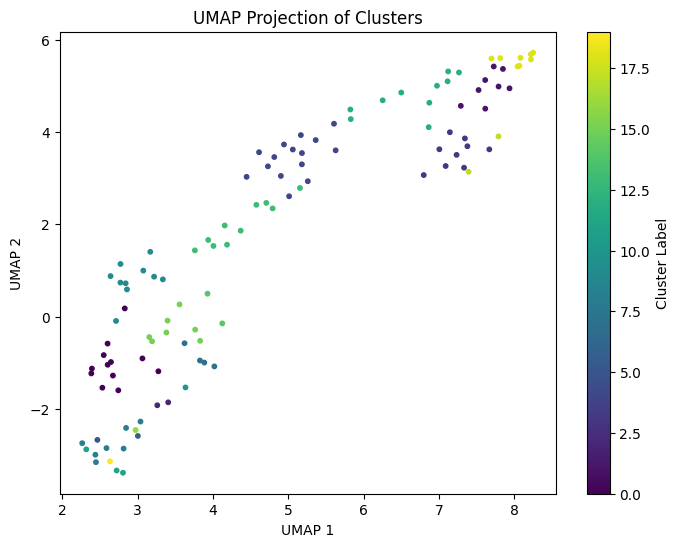

In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from umap.umap_ import UMAP

def extract_features(spec):
    """
    Extracts fixed-length features from a spectrogram using global average pooling.
    Returns a vector of length equal to the number of Mel bands.
    """
    return np.mean(spec, axis=1)

# Extract features for each processed spectrogram
X = np.array([extract_features(spec) for spec in processed_spectrograms])


# Reduce dimensionality with PCA
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

# Apply k-means clustering (choose number of clusters based on domain knowledge or using an elbow method)
n_clusters = 20  # e.g., you expect about 10 natural groupings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Optionally, reduce dimensions for visualization using UMAP
umap_embed = UMAP(n_components=2, random_state=42).fit_transform(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embed[:, 0], umap_embed[:, 1], c=clusters, cmap='viridis', s=10)
plt.title("UMAP Projection of Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Cluster Label')
plt.show()


## k means prediction

In [10]:
from sklearn.metrics import confusion_matrix
# This part requires domain knowledge and analysis of your data.
# For simplicity, I'll create a random mapping for demonstration.
unique_labels = np.unique(labels)
species_codes = sorted(train_df["primary_label"].unique())
if len(unique_labels) > len(species_codes):
    print("Warning: More clusters than species. Some clusters will be mapped to the same species.")
    cluster_to_species = {cluster: species_codes[cluster % len(species_codes)] for cluster in unique_labels}
else:
    cluster_to_species = {cluster: species_codes[cluster] if cluster < len(species_codes) else random.choice(species_codes) for cluster in unique_labels}

# Map cluster labels to predicted species labels
predicted_species = [cluster_to_species[label] for label in labels]

# Extract actual species labels for the subset of data
subset_filenames = [file_path.split(os.sep)[-1] for file_path in [os.path.join(TRAIN_AUDIO_DIR, fname) for fname in subset_files]]
actual_species = [train_df[train_df["filename"] == filename]["primary_label"].values[0] for filename in subset_filenames]

# Calculate right and wrong predictions
right_predictions = 0
wrong_predictions = 0

for i in range(len(actual_species)):
    if actual_species[i] == predicted_species[i]:
        right_predictions += 1
    else:
        wrong_predictions += 1

# Print the results
print(f"Right Predictions: {right_predictions}")
print(f"Wrong Predictions: {wrong_predictions}")

NameError: name 'labels' is not defined

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def create_wavenet_model(input_shape, num_classes, dropout_rate=0.15, num_filters=32, dense_units=128, dilation_rates=None):
    if dilation_rates is None:
        dilation_rates = [1, 2, 4, 8, 12, 16, 32, 64, 128]

    inputs = layers.Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for dilation_rate in dilation_rates:
        residual = x  # Store input for residual connection
        x = layers.Conv1D(num_filters, kernel_size=2, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        
        # Residual connection
        x = layers.Add()([x, residual])
        skip_connections.append(x)

    # Combine skip connections
    x = layers.Add()(skip_connections)
    x = layers.ReLU()(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='sigmoid')  # Use softmax if single-label classification

    model = tf.keras.Model(inputs, x)
    return model


## Model

## Model training

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 conv1d_46 (Conv1D)          (None, None, 32)          160       
                                                                 
 batch_normalization_54 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 conv1d_47 (Conv1D)          (None, None, 32)          2080      
                                                                 
 batch_normalization_55 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 conv1d_48 (Conv1D)          (None, None, 32)          2080

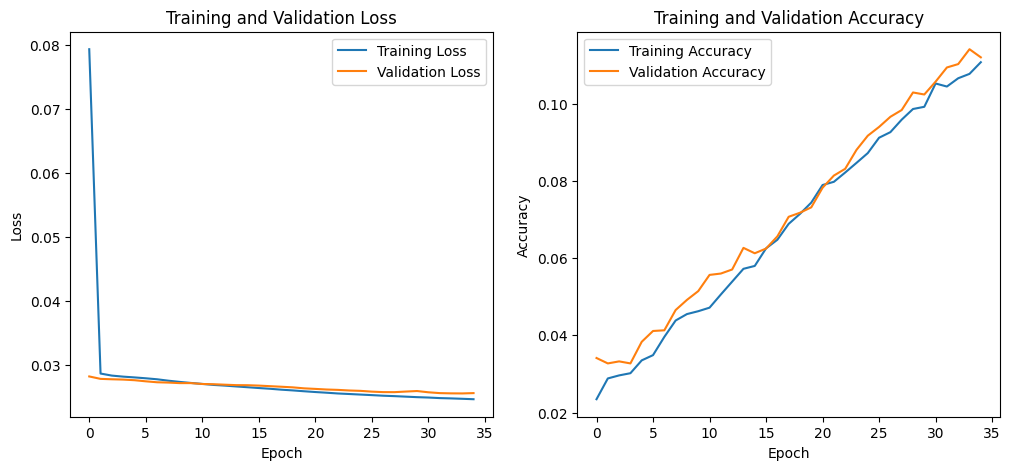

Submission file generated: submission.csv


In [30]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import noisereduce as nr
from scipy.signal import butter, filtfilt
from tensorflow.keras import layers

# ============================
# Global Parameters & Paths
# ============================
SR = 32000
N_MELS = 128
HOP_LENGTH = 512
DURATION = 5.0
BATCH_SIZE = 8
EPOCHS = 35

BASE_DIR = r"C:\BIRD"  # Change to your data directory
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train.csv")
TEST_SOUNDCAPES_DIR = os.path.join(BASE_DIR, "test_soundscapes")
SAMPLE_SUBMISSION_PATH = os.path.join(BASE_DIR, "sample_submission.csv")

# ============================
# Audio Processing Functions
# ============================
def load_audio(path, sr=SR, duration=None):
    audio, _ = librosa.load(path, sr=sr, duration=duration)
    return audio

def bandpass_filter(audio, lowcut=300.0, highcut=8000.0, sr=SR, order=6):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, audio)

def adaptive_noise_reduction(audio, sr=SR):
    reduced_audio = nr.reduce_noise(y=audio, sr=sr, stationary=False)
    return reduced_audio

def compute_mel_spectrogram(audio, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def process_mel_spectrogram(audio):
    audio_bandpassed = bandpass_filter(audio)
    audio_denoised = adaptive_noise_reduction(audio_bandpassed)
    mel_spec = compute_mel_spectrogram(audio_denoised)
    return mel_spec

# ============================
# Data Loading and Preprocessing
# ============================
train_df = pd.read_csv(TRAIN_CSV_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

species_codes = sorted(train_df["primary_label"].unique())
species_to_index = {code: i for i, code in enumerate(species_codes)}
num_species = len(species_codes)

def label_to_onehot(label):
    onehot = np.zeros(num_species, dtype=np.float32)
    if label in species_to_index:
        onehot[species_to_index[label]] = 1.0
    return onehot

train_file_paths = [os.path.join(TRAIN_AUDIO_DIR, fname) for fname in train_df["filename"].values]
train_labels = [label_to_onehot(lbl) for lbl in train_df["primary_label"].values]

train_paths, val_paths, train_lab, val_lab = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)

# ============================
# tf.data.Dataset Creation
# ============================
def generator(paths, labels):
    for path, label in zip(paths, labels):
        audio = load_audio(path, duration=DURATION)
        mel_spec_processed = process_mel_spectrogram(audio)
        mel_spec_unprocessed = compute_mel_spectrogram(audio)
        mel_spec_processed = np.mean(mel_spec_processed, axis=0)
        mel_spec_unprocessed = np.mean(mel_spec_unprocessed, axis=0)

        min_len = min(len(mel_spec_processed),len(mel_spec_unprocessed))

        mel_spec_processed = mel_spec_processed[:min_len]
        mel_spec_unprocessed = mel_spec_unprocessed[:min_len]

        mel_spec_combined = np.stack((mel_spec_processed, mel_spec_unprocessed), axis=-1)
        yield mel_spec_combined, label

def process_test_soundscape(file_path, segment_duration=5.0, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    audio = load_audio(file_path, sr=sr)
    total_duration = librosa.get_duration(y=audio, sr=sr)
    segments = []
    start = 0.0
    while start + segment_duration <= total_duration:
        segment = audio[int(start * sr): int((start + segment_duration) * sr)]
        mel_spec = compute_mel_spectrogram(segment, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec = np.mean(mel_spec, axis=0)
        segments.append(mel_spec)
        start += segment_duration
    return segments

output_shapes = ((None, 2), (num_species,))
output_types = (tf.float32, tf.float32)

train_dataset = tf.data.Dataset.from_generator(lambda: generator(train_paths, train_lab), output_types=output_types, output_shapes=output_shapes)
val_dataset = tf.data.Dataset.from_generator(lambda: generator(val_paths, val_lab), output_types=output_types, output_shapes=output_shapes)

train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None, 2], [num_species]))
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([None, 2], [num_species]))

# ============================
# Model Instantiation and Compilation
# ============================
def create_wavenet_model(input_shape, num_classes, dropout_rate=0.15):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    num_filters = 32
    for dilation_rate in [1, 2, 4, 8, 12, 16, 32, 64, 128]:
        x = layers.Conv1D(num_filters, 2, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, x)
    return model

model = create_wavenet_model(input_shape=(None, 2), num_classes=num_species, dropout_rate=0.15)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ============================
# Model Training with Early Stopping
# ============================
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping], verbose=1)

# ============================
# Evaluation
# ============================
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

print("Training Complete")

# Training Plots
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)

# ============================
# Test Soundscape Processing & Prediction
# ============================
def process_test_soundscape(file_path, segment_duration=5.0, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    audio = load_audio(file_path, sr=sr)
    total_duration = librosa.get_duration(y=audio, sr=sr)
    segments = []
    start = 0.0
    while start + segment_duration <= total_duration:
        segment = audio[int(start * sr): int((start + segment_duration) * sr)]
        mel_spec = compute_mel_spectrogram(segment, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec = np.mean(mel_spec, axis=0) # flatten the mel spec
        segments.append(mel_spec)
        start += segment_duration
    return segments

# Loop over test soundscape files to generate predictions
test_files = [os.path.join(TEST_SOUNDCAPES_DIR, f) for f in os.listdir(TEST_SOUNDCAPES_DIR) if f.endswith('.ogg')]
predictions = {}

for file_path in test_files:
    segments = process_test_soundscape(file_path)
    segment_preds = []
    for seg in segments:
        # Add batch dimension and (if needed) pad to match model input shape
        seg_tensor = tf.expand_dims(seg, 0)
        pred = model(seg_tensor, training=False).numpy()[0]
        segment_preds.append(pred)
    # Average predictions across all segments in the soundscape
    avg_pred = np.mean(segment_preds, axis=0)
    predictions[os.path.basename(file_path)] = avg_pred

# ============================
# Submission Generation
# ============================
# The sample_submission.csv file provides the expected format.
# Here, we assume each row_id corresponds to a 1-minute soundscape. Adjust the mapping as required.
submission = sample_submission.copy()

# Example: if row_id is formatted as "soundscape_xxxxxx_XX", extract the file identifier.
for idx, row in submission.iterrows():
    parts = row['row_id'].split('_')
    if len(parts) >= 2:
        file_id = parts[1]
        file_name = f"soundscape_{file_id}.ogg"
        if file_name in predictions:
            submission.loc[idx, submission.columns[1:]] = predictions[file_name]
        else:
            # If no prediction exists for a file, fill with zeros.
            submission.loc[idx, submission.columns[1:]] = 0.0

submission.to_csv("submission.csv", index=False)
print("Submission file generated: submission.csv")

# ============================
# Main Execution Block
# ============================
if __name__ == "__main__":
    pass

c:\Users\caspe\anaconda3\envs\BIRD\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


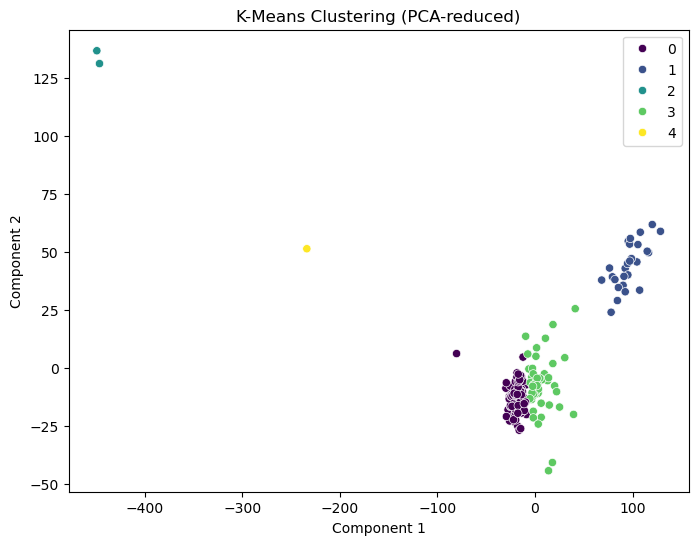

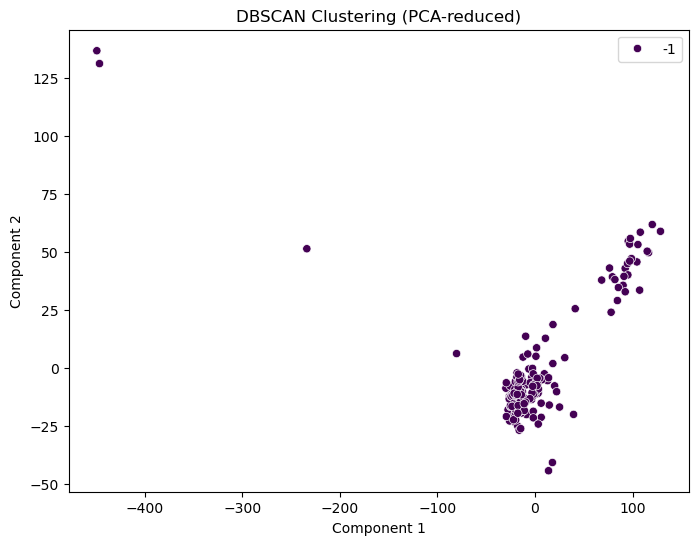

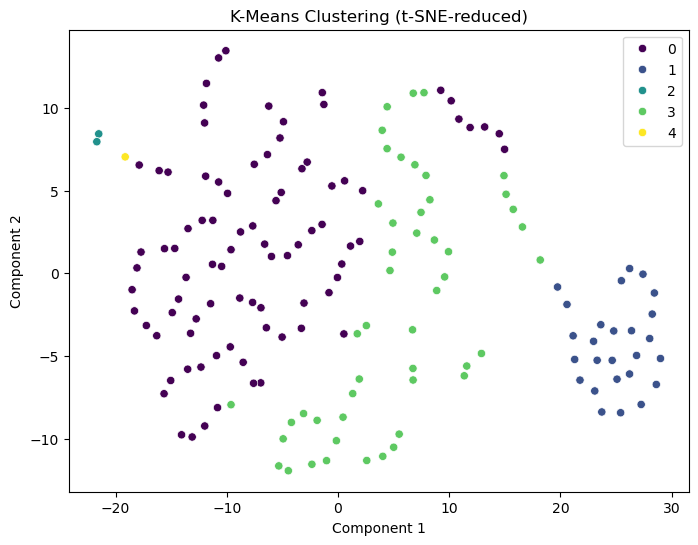

In [23]:
# ============================
# Dimensionality Reduction
# ============================

# Apply PCA to reduce Mel-spectrogram data to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(mel_spec.T)  # Transpose if needed

# Apply t-SNE for comparison
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(mel_spec.T)

# ============================
# Clustering
# ============================

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_features)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_features)

# ============================
# Visualization
# ============================

def plot_clusters(features, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Plot K-Means Clusters
plot_clusters(pca_features, kmeans_labels, "K-Means Clustering (PCA-reduced)")

# Plot DBSCAN Clusters
plot_clusters(pca_features, dbscan_labels, "DBSCAN Clustering (PCA-reduced)")

# Plot t-SNE Visualization
plot_clusters(tsne_features, kmeans_labels, "K-Means Clustering (t-SNE-reduced)")


In [26]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import noisereduce as nr
from scipy.signal import butter, filtfilt
import whisper

# ============================
# Global Parameters & Paths
# ============================
SR = 32000
TARGET_SR = 16000
N_MELS = 128
HOP_LENGTH = 512
DURATION = 5.0
BATCH_SIZE = 8
EPOCHS = 1000
PATIENCE = 4  # Early stopping patience

BASE_DIR = r"C:\BIRD"  # Change to your data directory
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train.csv")

# ============================
# Load Metadata
# ============================
train_df = pd.read_csv(TRAIN_CSV_PATH)
species_codes = sorted(train_df["primary_label"].unique())
species_to_index = {code: i for i, code in enumerate(species_codes)}
num_species = len(species_codes)

# ============================
# Load Whisper Model
# ============================
model_whisper = whisper.load_model("base")

# ============================
# Audio Processing Functions
# ============================
def load_audio(path, sr=SR, duration=None):
    audio, _ = librosa.load(path, sr=sr, duration=duration)
    return audio

def bandpass_filter(audio, lowcut=300.0, highcut=8000.0, sr=SR, order=6):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, audio)

def adaptive_noise_reduction(audio, sr=SR):
    return nr.reduce_noise(y=audio, sr=sr, stationary=False)

def compute_mel_spectrogram(audio, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    return librosa.power_to_db(S, ref=np.max)

def process_mel_spectrogram(audio):
    audio_bandpassed = bandpass_filter(audio)
    audio_denoised = adaptive_noise_reduction(audio_bandpassed)
    return compute_mel_spectrogram(audio_denoised)

def preprocess_whisper_audio(audio, sr=SR):
    if sr != TARGET_SR:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)
    audio = whisper.pad_or_trim(audio)
    return whisper.log_mel_spectrogram(audio).cpu().numpy()

# ============================
# Label Encoding
# ============================
def label_to_onehot(label):
    onehot = np.zeros(num_species, dtype=np.float32)
    if label in species_to_index:
        onehot[species_to_index[label]] = 1.0
    return onehot

train_file_paths = [os.path.join(TRAIN_AUDIO_DIR, fname) for fname in train_df["filename"].values]
train_labels = [label_to_onehot(lbl) for lbl in train_df["primary_label"].values]

train_paths, val_paths, train_lab, val_lab = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)

# ============================
# Data Generator using Whisper Features
# ============================
def generator(paths, labels):
    for path, label in zip(paths, labels):
        try:
            audio = load_audio(path, duration=DURATION)
            whisper_spec = preprocess_whisper_audio(audio, sr=SR)
            whisper_embedding = np.mean(whisper_spec, axis=1)
            custom_mel = process_mel_spectrogram(audio)
            custom_embedding = np.mean(custom_mel, axis=1)
            combined_features = np.concatenate((whisper_embedding, custom_embedding), axis=-1)
            yield combined_features, label
        except Exception as e:
            dummy_features = np.zeros(final_feature_dim, dtype=np.float32)
            dummy_label = np.zeros(num_species, dtype=np.float32)
            yield dummy_features, dummy_label

dummy_audio = load_audio(train_paths[0], duration=DURATION)
dummy_whisper = np.mean(preprocess_whisper_audio(dummy_audio, sr=SR), axis=1)
dummy_custom = np.mean(process_mel_spectrogram(dummy_audio), axis=1)
final_feature_dim = dummy_whisper.shape[0] + dummy_custom.shape[0]

output_shapes = ((final_feature_dim,), (num_species,))
output_types = (tf.float32, tf.float32)

train_dataset = tf.data.Dataset.from_generator(lambda: generator(train_paths, train_lab), output_types=output_types, output_shapes=output_shapes).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_generator(lambda: generator(val_paths, val_lab), output_types=output_types, output_shapes=output_shapes).batch(BATCH_SIZE)

# ============================
# WaveNet Model Definition
# ============================
def create_wavenet_model(input_shape, num_classes, dropout_rate=0.15, num_filters=32, dense_units=128, dilation_rates=None):
    if dilation_rates is None:
        dilation_rates = [1, 2, 4, 8, 12, 16, 32, 64, 128]
    inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], 1))(inputs)
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(filters=num_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_wavenet_model((final_feature_dim,), num_species)

# ============================
# Custom Callback for Logging (Normal)
# ============================
class TrainingLogger(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}/{EPOCHS} Started...")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# ============================
# Training
# ============================
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[TrainingLogger(), early_stopping])

# ============================
# Saving Model
# ============================
model.save("whisper_species_classifier.h5")
print("Model training complete. Saved as whisper_species_classifier.h5")


Epoch 1/1000 Started...
Epoch 1/1000
   2857/Unknown 3135s 1s/step - accuracy: 0.0262 - loss: 4.8250

c:\Users\caspe\anaconda3\envs\BIRD\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 1/1000 - Loss: 4.7684, Accuracy: 0.0304
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 3936s 1s/step - accuracy: 0.0262 - loss: 4.8249 - val_accuracy: 0.0355 - val_loss: 4.7420

Epoch 2/1000 Started...
Epoch 2/1000
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0329 - loss: 4.7408Epoch 2/1000 - Loss: 4.7388, Accuracy: 0.0326
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 4117s 1s/step - accuracy: 0.0329 - loss: 4.7408 - val_accuracy: 0.0355 - val_loss: 4.7411

Epoch 3/1000 Started...
Epoch 3/1000
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0328 - loss: 4.7388Epoch 3/1000 - Loss: 4.7357, Accuracy: 0.0333
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 4120s 1s/step - accuracy: 0.0328 - loss: 4.7388 - val_accuracy: 0.0355 - val_loss: 4.7420

Epoch 4/1000 Started...
Epoch 4/1000
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0338 - loss: 4.7383Epoch 4/1000 - Loss: 4.7348, Accuracy: 0.0338
2857/2857 ━━━━━━━━━━━━━━━━━━━━ 4126s 1s/step - accuracy: 0.0338 - loss: 4.7383 - val_accuracy: 0.0355 - val_loss: 

KeyboardInterrupt: 

In [22]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import whisper
import soundfile as sf

# ============================
# Global Parameters & Paths
# ============================
SR = 32000
TARGET_SR = 16000
DURATION = 5.0
BATCH_SIZE = 2
EPOCHS = 5

# Create a small dummy dataset
BASE_DIR = "test_data"
os.makedirs(os.path.join(BASE_DIR, "train_audio"), exist_ok=True)
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "train_audio")
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train.csv")

# Create dummy audio files and CSV
dummy_data = [
    {"filename": "audio1.wav", "primary_label": "speciesA"},
    {"filename": "audio2.wav", "primary_label": "speciesB"},
    {"filename": "audio3.wav", "primary_label": "speciesA"},
    {"filename": "audio4.wav", "primary_label": "speciesB"},
    {"filename": "audio5.wav", "primary_label": "speciesC"},
    {"filename": "audio6.wav", "primary_label": "speciesC"},
]

df = pd.DataFrame(dummy_data)
df.to_csv(TRAIN_CSV_PATH, index=False)

for row in dummy_data:
    audio_path = os.path.join(TRAIN_AUDIO_DIR, row["filename"])
    tone = librosa.tone(frequency=440, sr=SR, duration=1.0)
    sf.write(audio_path, tone, SR)

# ============================
# Load Metadata
# ============================
train_df = pd.read_csv(TRAIN_CSV_PATH)
species_codes = sorted(train_df["primary_label"].unique())
species_to_index = {code: i for i, code in enumerate(species_codes)}
num_species = len(species_codes)

# ============================
# Load Whisper Model
# ============================
model_whisper = whisper.load_model("tiny")

# ============================
# Audio Processing Functions (Simplified)
# ============================
def load_audio(path, sr=SR, duration=None):
    audio, _ = librosa.load(path, sr=sr, duration=duration)
    return audio

def preprocess_whisper_audio(audio, sr=SR):
    if sr != TARGET_SR:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)
    audio = whisper.pad_or_trim(audio)
    return whisper.log_mel_spectrogram(audio).cpu().numpy()

# ============================
# Label Encoding
# ============================
def label_to_onehot(label):
    onehot = np.zeros(num_species, dtype=np.float32)
    if label in species_to_index:
        onehot[species_to_index[label]] = 1.0
    return onehot

train_file_paths = [os.path.join(TRAIN_AUDIO_DIR, fname) for fname in train_df["filename"].values]
train_labels = [label_to_onehot(lbl) for lbl in train_df["primary_label"].values]

train_paths, val_paths, train_lab, val_lab = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)

# ============================
# Data Generator using Whisper Features
# ============================
def generator(paths, labels):
    for path, label in zip(paths, labels):
        try:
            audio = load_audio(path, duration=DURATION)
            whisper_spec = preprocess_whisper_audio(audio, sr=SR)
            whisper_embedding = np.mean(whisper_spec, axis=1)
            yield whisper_embedding, label
        except Exception as e:
            dummy_features = np.zeros(final_feature_dim, dtype=np.float32)
            dummy_label = np.zeros(num_species, dtype=np.float32)
            yield dummy_features, dummy_label

dummy_audio = load_audio(train_paths[0], duration=DURATION)
dummy_whisper = np.mean(preprocess_whisper_audio(dummy_audio, sr=SR), axis=1)
final_feature_dim = dummy_whisper.shape[0]

output_shapes = ((final_feature_dim,), (num_species,))
output_types = (tf.float32, tf.float32)

train_dataset = tf.data.Dataset.from_generator(lambda: generator(train_paths, train_lab), output_types=output_types, output_shapes=output_shapes).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_generator(lambda: generator(val_paths, val_lab), output_types=output_types, output_shapes=output_shapes).batch(BATCH_SIZE)

# ============================
# WaveNet Model Definition (Simplified)
# ============================
def create_wavenet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], 1))(inputs)
    x = layers.Conv1D(filters=8, kernel_size=2, padding="causal", dilation_rate=1, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_wavenet_model((final_feature_dim,), num_species)

# ============================
# Custom Callback for Logging
# ============================
class TrainingLogger(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1}/{EPOCHS} Started...\n")

    def on_train_batch_end(self, batch, logs=None):
        print(f"\nEpoch {self.params['epochs']}, Iteration {batch + 1}: Loss={logs['loss']:.4f}, Accuracy={logs['accuracy']:.4f}\n")

# ============================
# Training
# ============================
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[TrainingLogger()])

# ============================
# Saving Model
# ============================
model.save("whisper_species_classifier_test.h5")
print("Model training complete. Saved as whisper_species_classifier_test.h5")


Epoch 1/5 Started...

Epoch 1/5

Epoch 5, Iteration 1: Loss=1.1453, Accuracy=0.0000

      1/Unknown 1s 809ms/step - accuracy: 0.0000e+00 - loss: 1.1453
Epoch 5, Iteration 2: Loss=1.0912, Accuracy=0.2500



c:\Users\caspe\anaconda3\envs\BIRD\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.1667 - loss: 1.1092 - val_accuracy: 0.5000 - val_loss: 1.1290

Epoch 2/5 Started...

Epoch 2/5

Epoch 5, Iteration 1: Loss=1.1431, Accuracy=0.0000

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0000e+00 - loss: 1.1431
Epoch 5, Iteration 2: Loss=1.0901, Accuracy=0.2500

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1667 - loss: 1.1077 - val_accuracy: 0.5000 - val_loss: 1.1301

Epoch 3/5 Started...

Epoch 3/5

Epoch 5, Iteration 1: Loss=1.1421, Accuracy=0.0000

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0000e+00 - loss: 1.1421
Epoch 5, Iteration 2: Loss=1.0894, Accuracy=0.2500

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1667 - loss: 1.1070 - val_accuracy: 0.5000 - val_loss: 1.1313

Epoch 4/5 Started...

Epoch 4/5

Epoch 5, Iteration 1: Loss=1.1413, Accuracy=0.0000

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0000e+00 - loss: 1.1413
Epoch 5, Iteration 2: Loss=1.0888, Accuracy=0.2500

2/2 ━━━━━━━━━━━

Model training complete. Saved as whisper_species_classifier_test.h5
